# The impact of ambient noise and model selection for sleep classification

1. Overview of setup for scoring based only on movement
    1. Input is accelerometer
    2. Then some preprocessing. Either actigraphy or specgram, or other.
    3. ML model => probabilities of being asleep, or WLDM probability.
2. Issue of noise. Dig up some old pics, or just post side-by-sides for same timestamps, same subject.
3. Explain the models.
    1. Classic Log Reg, interp as single layer CNN 1d
    2. MO UNet, defer to publication.
    3. SmartMap, Naive


## The pipeline from movement to awake-asleep classification

Most, if not all, methods of automatic sleep scoring in use today is based on triaxial accelerometer data. This applies to both clinical sleep tracking and smart devices in tech. These data record the acceleration in the x-, y-, and z-axis of a smart watch or phone, measured in units of the Earth's gravity _g_ = 9.8 m/s^2; typically, sampling is at 50 or 100 Hz.

We'll use the Pisces library to analyze ...

In [1]:
# Let's load some accelerometer data and plot it
from pisces.data_sets import DataSetObject

import os
from pathlib import Path

CWD = Path(os.getcwd())
# hardcoded data locations are easiest, if most brittle
data_location = CWD.parent.parent.joinpath('data_sets')
print("Looking for data in ", data_location)

# This assumes you have set up the walch_et_al data set. See [this notebook]() for how to do that.
sets = DataSetObject.find_data_sets(data_location)
walch = sets['walch_et_al']
walch.parse_data_sets()
print(f"Found {len(walch.ids)} subjects")

Looking for data in  /Users/eric/Engineering/Work/pisces/data_sets
Found 31 subjects


In [2]:
walch_0 = walch.ids[0]

w0_accel = walch.get_feature_data( 'accelerometer', walch_0,)

In [3]:
# The data has 4 columns.
# column_1 is the time in seconds from start of PSG recording
# column_2 is the x-axis acceleration, columns 3 and 4 are the y and z axes.
w0_accel.head()

column_1,column_2,column_3,column_4
f64,f64,f64,f64
0.015948,0.403931,0.449005,-0.79686
0.036006,0.403915,0.448029,-0.795395
0.055885,0.404907,0.446549,-0.795853
0.075883,0.408356,0.447525,-0.796768
0.095875,0.406891,0.44458,-0.79628


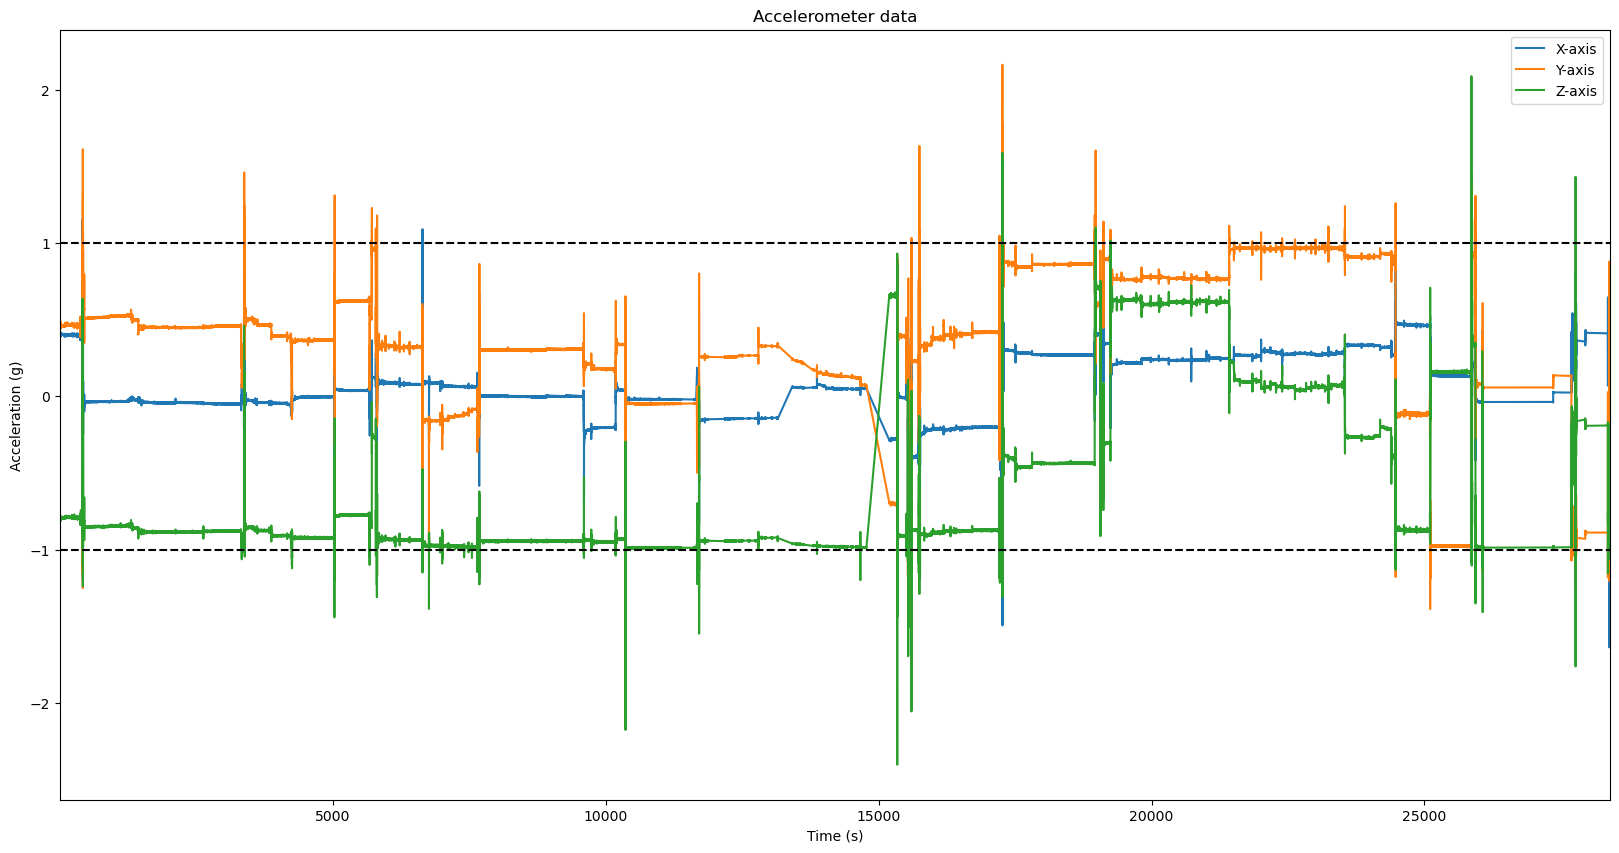

In [4]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(20, 10))

axis_names = ['Time (s)', 'X-axis', 'Y-axis', 'Z-axis']

for i in range(1, 4):
    ax.plot(w0_accel[:, 0], w0_accel[:, i], label=axis_names[i])

# draw horizontal -- lines at +/- 1g
ax.axhline(1, color='black', linestyle='--')
ax.axhline(-1, color='black', linestyle='--')

ax.set_xlim(w0_accel[0, 0], w0_accel[-1, 0])
ax.set_title("Accelerometer data")
ax.set_xlabel(axis_names[0])
ax.set_ylabel("Acceleration (g)")
ax.legend()

For clinical sleep tracking, the standard has long been Cole-Kripke like methods based on highly filtered and aggregated _actigraphy_ data. The specifics of the filtering and aggregation were proprietary until a few years ago (e.g. ActiGraph algorithm on GitHub) though it is possible to reverse-engineer these algorithms on specific data sets (e.g. te Lindert, _et al_). Once processed, a weighted sum of this data in a sliding window is taken, with weights determined by gradient descent methods.

Pisces has Arcascope's ADS processing, which is more robust to noise (more on this later). It also has _te Lindert et al_'s reverse-engineering, and is compatible with the `ag_counts` except for the python version restriction to <3.10 (hence the library is not integrated here).

In [5]:
from pisces.utils import build_activity_counts, ActivityCountAlgorithm, build_ADS, build_activity_counts_te_Lindert_et_al

# Let's build some activity counts
# We'll use the default activity count algorithm, which is a simple threshold-based algorithm.
# w0_ads = build_activity_counts(w0_accel, ActivityCountAlgorithm.ADS)
w0_ads = build_ADS(w0_accel)
w0_tL = build_activity_counts_te_Lindert_et_al(w0_accel)


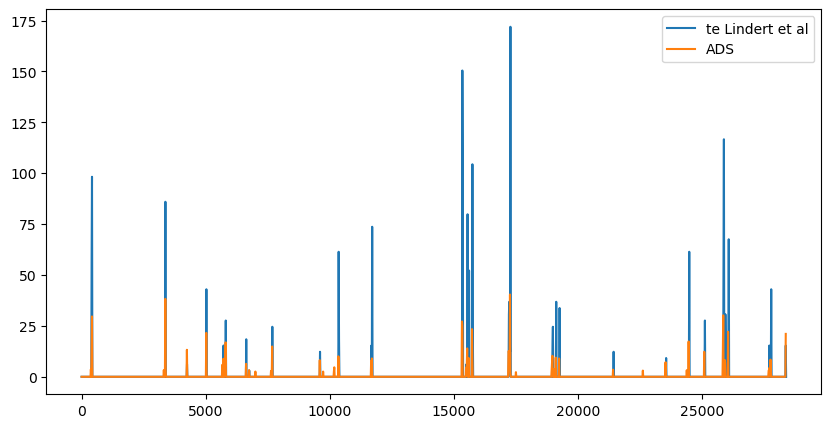

In [6]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(w0_tL[0], w0_tL[1], label='te Lindert et al')
ax.plot(w0_ads[0], w0_ads[1], label='ADS')
ax.legend()

The field of automatic scoring in consumer tech smart watches has clustered around more sophisticated techniques utilizing the high-resolution and high fidelity of consumer accelerometers. One well-known approach is to take a spectrogram, or power-spectrum decomposition, of this data. See, e.g., (Canton & Walch GitHub), Mads Olsen, ...

Spectrograms are processed by deep neural networks akin to image segmenters, which instead of outputting _a cat is over here_ or _a dump truck is here_ identifies _this segment looks like someone in REM sleep_, etc.

In [16]:
def transform_to_range(array, new_min, new_max):
    old_min = array.min()
    old_max = array.max()
    return (array - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

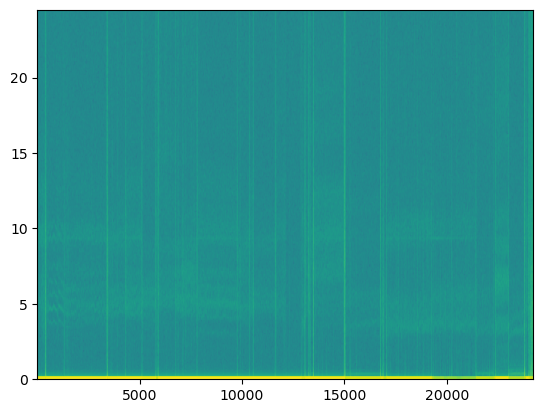

In [22]:
# We provide an example of a spectrogram. Specific ML models will have their own configurations of NFFT, pre-transform resampling, etc.

import numpy as np


w0_time = w0_accel[:, 0]
w0_accel_x = w0_accel[:, 1]
w0_accel_y = w0_accel[:, 2]
w0_accel_z = w0_accel[:, 3]

# Compute the median sampling rate
median_Hz = int(1 / np.median(np.diff(w0_time)))
nfft = 512
overlap = nfft // 2


# Compute the spectrogram for each axis
spec_x, _, _, _ = plt.specgram(w0_accel_x, NFFT=nfft, Fs=median_Hz, noverlap=overlap, cmap='viridis')
spec_y, _, _, _ = plt.specgram(w0_accel_y, NFFT=nfft, Fs=median_Hz, noverlap=overlap, cmap='viridis')
spec_z, _, _, _ = plt.specgram(w0_accel_z, NFFT=nfft, Fs=median_Hz, noverlap=overlap, cmap='viridis')

max_value_img = 0.33
spec_x = transform_to_range(spec_x, 0, max_value_img)
spec_y = transform_to_range(spec_y, 0, max_value_img)
spec_z = transform_to_range(spec_z, 0, max_value_img)
# Combine the spectrograms into an RGB image
rgb_spec = np.stack((spec_x, spec_y, spec_z), axis=-1)

In [23]:
rgb_spec.shape

(257, 4639, 3)

Text(0.5, 1.0, 'RGB Spectrogram of Accelerometer Data')

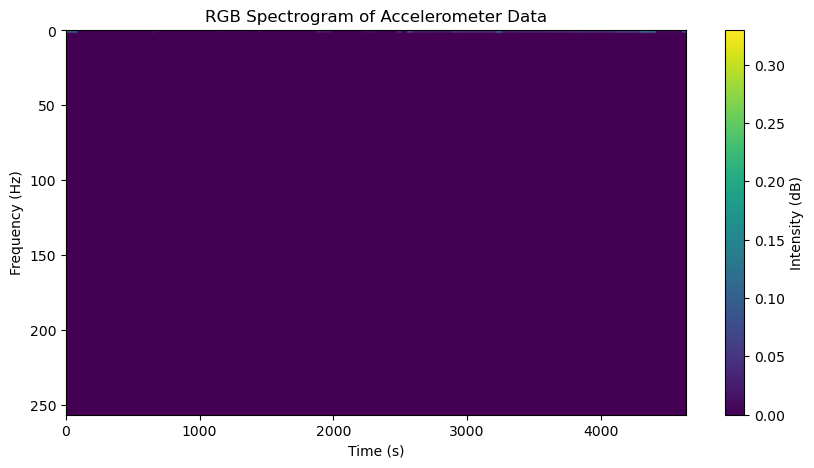

In [26]:

# Plot the RGB spectrogram
plt.figure(figsize=(10, 5))
plt.imshow(rgb_spec[..., 0], aspect='auto')#, extent=[bins.min(), bins.max(), freqs.min(), freqs.max()])
plt.colorbar().set_label('Intensity (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('RGB Spectrogram of Accelerometer Data')

## The challenge of Noise

In [28]:

hybrid = sets['hybrid_motion']
hybrid.parse_data_sets()
print(f"Found {len(hybrid.ids)} subjects")

Found 31 subjects


In [30]:
hybrid_0 = hybrid.ids[0]

h0_accel = hybrid.get_feature_data( 'accelerometer', hybrid_0,)

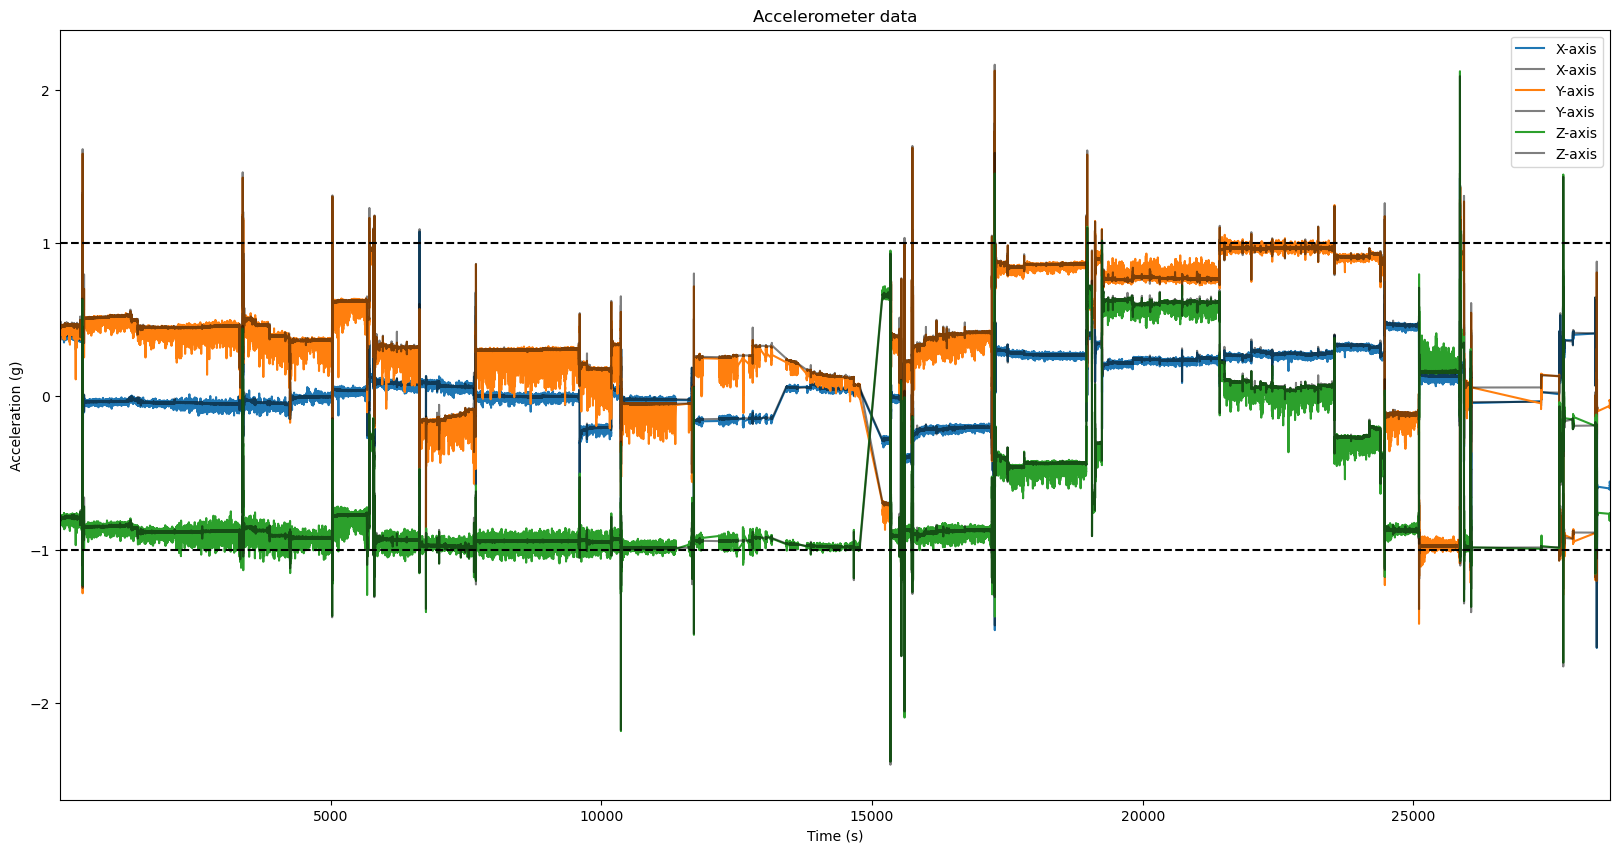

In [31]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(20, 10))

axis_names = ['Time (s)', 'X-axis', 'Y-axis', 'Z-axis']

for i in range(1, 4):
    ax.plot(h0_accel[:, 0], h0_accel[:, i], label=axis_names[i])
    ax.plot(w0_accel[:, 0], w0_accel[:, i], label=axis_names[i], c='black', alpha=0.5)

# draw horizontal -- lines at +/- 1g
ax.axhline(1, color='black', linestyle='--')
ax.axhline(-1, color='black', linestyle='--')

ax.set_xlim(h0_accel[0, 0], h0_accel[-1, 0])
ax.set_title("Accelerometer data")
ax.set_xlabel(axis_names[0])
ax.set_ylabel("Acceleration (g)")
ax.legend()

# ROC Explainer

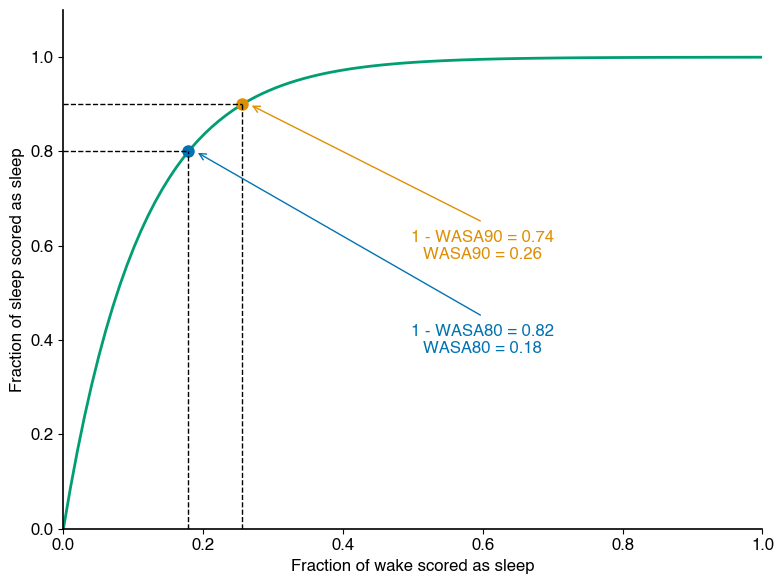

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Setting font and style parameters
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12

# Color palette
color_palette = sns.color_palette("colorblind")

# Data for the curve
DECAY = 9
def roc_map(x):
    return 1 - np.exp(-x * DECAY)
def roc_inv_map(y):
    return -np.log(1 - y) / DECAY 
x = np.linspace(0, 1, 100)
y = roc_map(x)

# WASA80 and WASA90 points
ps_to_check = [0.8, 0.9]
wasa80_y = 0.8
wasa80_x = roc_inv_map(wasa80_y)
wasa90_y = 0.9
wasa90_x = roc_inv_map(wasa90_y)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, color=color_palette[2], linewidth=2)

# Adding points for WASA80 and WASA90
ax.plot(wasa80_x, wasa80_y, 'o', color=color_palette[0], markersize=8, label="WASA80")
ax.plot(wasa90_x, wasa90_y, 'o', color=color_palette[1], markersize=8, label="WASA90")

# Adding dashed lines for visual reference
ax.hlines(wasa80_y, 0, wasa80_x, color='black', linestyle='--', linewidth=1)
ax.vlines(wasa80_x, 0, wasa80_y, color='black', linestyle='--', linewidth=1)
ax.hlines(wasa90_y, 0, wasa90_x, color='black', linestyle='--', linewidth=1)
ax.vlines(wasa90_x, 0, wasa90_y, color='black', linestyle='--', linewidth=1)

# Annotations for the WASA points using f-strings and aligned vertically at x=0.6
text_x = 0.6  # Fixed x position for annotations
text_wasa80_y = 0.4  # Custom y position for WASA80 annotation
text_wasa90_y = text_wasa80_y + 0.2 # Custom y position for WASA90 annotation
arrow_offset_y = 0.05
arrow_offset_x = 0.01

# Adding WASA80 annotation with an arrow
ax.text(
    text_x, text_wasa80_y,
    f"1 - WASA80 = {1 - wasa80_x:.2f}\nWASA80 = {wasa80_x:.2f}", 
    color=color_palette[0], ha='center', va='center'
)
ax.annotate(
    '', xy=(wasa80_x + arrow_offset_x, wasa80_y), xytext=(text_x, text_wasa80_y + arrow_offset_y),
    arrowprops=dict(arrowstyle="->", color=color_palette[0])
)

# Adding WASA90 annotation with an arrow
ax.text(
    text_x, text_wasa90_y,
    f"1 - WASA90 = {1 - wasa90_x:.2f}\nWASA90 = {wasa90_x:.2f}", 
    color=color_palette[1], ha='center', va='center'
)
ax.annotate(
    '', xy=(wasa90_x + arrow_offset_x, wasa90_y), xytext=(text_x, text_wasa90_y + arrow_offset_y),
    arrowprops=dict(arrowstyle="->", color=color_palette[1])
)

# Axis labels
ax.set_xlabel("Fraction of wake scored as sleep")
ax.set_ylabel("Fraction of sleep scored as sleep")

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize the remaining spines (left and bottom)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Set limits
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.1)

# Show plot
plt.tight_layout()
plt.show()
